In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import math

import pandas as pd
import time

from time import time
from time import *

from mpl_toolkits.mplot3d import Axes3D

import statistics as st

import gc 

from datetime import datetime
import tqdm

This code consists of several functions for a Hopfield Network. Some of the functions are:

    IsScalar: returns a Boolean indicating whether the input is a scalar (not a list or numpy array).
    Thresh: threshold function that returns -1 for negative input and 1 for positive input.
    Transpose: returns the transpose of the input array.
    weight: returns the dot product of the transpose of the input array with the input array.
    weight_self: returns the dot product of the transpose of the input array with the input array, after applying the Thresh function.
    randomize: generates random values without repetition.
    randd: generates random permutation.
    Hamming: returns the number of elements in two arrays that are different.
    Mod_Hamming: returns the number of elements in two arrays that are different, with a special case when the arrays are negations of each other.
    prime_generator: returns a list of prime numbers up to a given end.
    Prime_List: returns a list of tuples of prime numbers, where each tuple consists of a prime number and a number that's close to it.
    Prime_range: returns a list of prime numbers in a given range.
    Update: returns the updated value in the Hopfield Network based on the current weight and input.
    Updateb: returns the updated value in the Hopfield Network based on the current weight and mean of input.
    add_percentage_noise: adds noise to an input array by flipping a certain percentage of its elements from 1 to -1 and vice versa.
    recall_memory: returns the Hamming distance between an updated rule and each pattern in the network.

In [2]:
# Useful functions
# @njit
def IsScalar(x):
    return not isinstance(x, (list, np.ndarray))
    

'''
Make sure the values in the hopefild Network 
are bipolar (-1,1)
'''
def Thresh(x):
    return np.sign(x)


'''
Define Transpose for special cases
'''
def Transpose(x):
    return np.transpose(x)


'''
Generate random Network with N Neurons and n Patterns
'''
def RandomNet(N, n=1):
    out = np.random.normal(size=(n, N)) if n != 1 else np.random.normal(size=N)
    return np.sign(out)



'''
# A function to calculate the weight of the vector
'''

def weight(v):
    N = v.shape[0]
    if v.ndim == 1:
        v = v.reshape(-1, 1)
        w = v @ v.T
    else:
        M = v.shape[1]
        v = v / np.sqrt(M)
        w = v.T @ v
        
        # w = (v / np.sqrt(M)).T @ v / M
    np.fill_diagonal(w, 0)
    return w



def weight_self(a):
    return Thresh(a.T @ a) - np.identity(a.shape[1])


'''
# A function to genetate random values without repeat
# Also for random permutation
'''
def randomize(N):
    return np.random.choice(N, size=N, replace=False)

def randd(N):
    return np.random.permutation(N)

    
'''
# A function that show the number cordinates that are different 
'''   
def Hamming(x,y):
    return np.count_nonzero(x!=y)

    
def Mod_Hamming(x,y):
    if (x==-1*y).all():
        return -1
    elif (-1*x==y).all():
        return -1
    else:
        return np.count_nonzero(x!=y)


'''
# Prime number generator
'''              

def prime_generator(end):
    primes = [True for i in range(end + 1)]
    p = 2
    while p * p <= end:
        if primes[p]:
            for i in range(p * 2, end + 1, p):
                primes[i] = False
        p += 1
    return [p for p in range(3, end) if primes[p]]

def Prime_List(l):
    a = prime_generator(l)
    out = [(i, i + int(0.09 * i)) for i in a]
    return out

def Prime_range(a, b):
    primes = prime_generator(b)
    out = [p for p in primes if p >= a]
    return out




'''
# A function for update in hopfield net
'''  

def hopfield_update(weights, inputs, threshold=0):
    """
    The optimized Hopfield network update rule with asynchronous update.
    Parameters:
    - weights (np.array): The weight matrix of the Hopfield network.
    - inputs (np.array): The current state of the Hopfield network.
    - threshold (int): The activation threshold.
    Returns:
    - updated_state (np.array): The updated state of the Hopfield network.
    """
    n = inputs.shape[0]
    updated_state = inputs.copy()
    for i in np.random.permutation(n):
        net_input = np.dot(weights[i], updated_state)
        if net_input > threshold:
            updated_state[i] = 1
        elif net_input < -threshold:
            updated_state[i] = -1
    return updated_state



'''
# Perturbation of the net
'''
def add_percentage_noise(x, noise_percentage = 0.1):
    '''
    Adds a percentage noise to an array.

    Parameters:
      x (ndarray): input array
      noise_percentage (float): percentage of elements to be noised (e.g. 0.1 for 10%)

    Returns:
      ndarray: array with added noise
    '''
    x_noised = x.copy()
    indices_to_noise = np.random.permutation(np.arange(x.shape[0]))[:int(x.shape[0] * noise_percentage)]
    x_noised[indices_to_noise] = np.where(x[indices_to_noise]==1, -1, 1)
    return x_noised



'''
# recall_memory is showing the Hamming distance of each pattern to an updated rule
'''

def recall_memory(v, x):
    N = v.shape[-1]
    o = -1 * x
    k = []
    j = []
    if len(v.shape) > 1:
        for idx, t in enumerate(v):
            d = Hamming(x, t)
            if d == N:
                if (o == t).all():
                    d = Hamming(o, t)
            k.append(d)
            j.append((d, idx))
        m = min(k)
        q = [index for (ham, index) in j if ham == m][0]
    else:
        d = Hamming(x, v)
        if d == N:
            if (o == v).all():
                d = Hamming(o, v)
        m = d
        q = 0
    a = 'at index '
    s = '{}{}'.format(a, q)
    return m, s




def Perturbed_memory(v, p):    
    len_v = v.shape[0] if len(v.shape) > 1 else 1
    k = np.random.randint(len_v)
    Y = Perturb(v, p=p) 
    x = Y[k:k+1, :] if len_v > 1 else Y
    v_k = v[k:k+1, :] if len_v > 1 else v
    err = np.count_nonzero(x != v_k)
    x_orig = x.copy()
    return np.squeeze(x_orig)



'''
# Fliping the values in x
'''
def flip(x):
    return -1 * x

def flipn(x,n):
    x[n] = -x[n]
    return x



'''
# A function to calculate the Energy
'''
# def HopfieldEnergy(W, x):
#     if x.ndim == 1:
#         x = x.reshape(1, -1) # reshape x to a 2D array with a single row
#     num_patterns = x.shape[0]
#     E = -0.5 * np.einsum('ij,ij->i', np.dot(x, W), x)
#     return E


# def Energy(W, x):
#     if x.ndim == 1:
#         x = x.reshape(1, -1) # reshape x to a 2D array with a single row
#     E = -0.5 * np.dot(x, np.dot(W, x.T))
#     # if E.size > 1:
#     #     raise ValueError("Energy calculation resulted in an array with more than one item.")
#     if len(E) > 1:
#         E
#     else:
#         E = E.item()
#     return E

def Energy(w, x):
    return -0.5 * np.dot(np.dot(x, w), x)


def new_Energy(v, x, a=2):
    return -np.sum(np.dot(v, x) ** a)



'''
Checking posible Capacity of the Network
'''
def capacity(v):
    n = v.shape[1] if len(v.shape) > 1 else v.shape[0]
    return n / (2 * math.log(n, 2))

def checkarr(arr):
    return np.isclose(arr, arr[0]).all()




In [3]:
N = 7
p = 3

v = RandomNet(N,p)
x = RandomNet(N)

n = 2

print('v:\n',v,'\n','x:\n',x)

v:
 [[ 1.  1. -1. -1. -1. -1.  1.]
 [-1. -1.  1.  1.  1. -1. -1.]
 [ 1. -1.  1.  1. -1.  1. -1.]] 
 x:
 [ 1.  1.  1. -1. -1.  1.  1.]


In [4]:
W = weight(v)

print('weight:',W,'\n \n',
      'Energy:',Energy(W, x),'\n \n',
      'new_Energy:',new_Energy(v, x, n),'\n \n',
      'capacity:',capacity(v),'\n \n',
      'recall_memory:',recall_memory(v,x),'\n \n',
      'add_percentage_noise:',add_percentage_noise(x, 0.2),'\n \n')

new_Energy(v, x, n)

weight: [[ 0.          0.14285714 -0.14285714 -0.14285714 -0.42857143  0.14285714
   0.14285714]
 [ 0.14285714  0.         -0.42857143 -0.42857143 -0.14285714 -0.14285714
   0.42857143]
 [-0.14285714 -0.42857143  0.          0.42857143  0.14285714  0.14285714
  -0.42857143]
 [-0.14285714 -0.42857143  0.42857143  0.          0.14285714  0.14285714
  -0.42857143]
 [-0.42857143 -0.14285714  0.14285714  0.14285714  0.         -0.14285714
  -0.14285714]
 [ 0.14285714 -0.14285714  0.14285714  0.14285714 -0.14285714  0.
  -0.14285714]
 [ 0.14285714  0.42857143 -0.42857143 -0.42857143 -0.14285714 -0.14285714
   0.        ]] 
 
 Energy: -0.9999999999999998 
 
 new_Energy: -35.0 
 
 capacity: 1.2467251548780776 
 
 recall_memory: (2, 'at index 0') 
 
 add_percentage_noise: [ 1.  1.  1. -1. -1. -1.  1.] 
 



-35.0

### Working

In [5]:
def in_stateW(weights, inputs, threshold=0):
    n = inputs.shape[0]
    updated_state = inputs.copy()
    for i in np.random.permutation(n):
        net_input = np.dot(weights[i], updated_state)
        updated_state[i] = 1 if net_input > threshold else -1
    return updated_state

In [6]:
def in_state_flipE(vin, inputs, g=2):  
    updated_state = inputs.copy()
    n = inputs.shape[0]
    new_v = vin.copy()
    for i in np.random.permutation(n): 
        in_state = updated_state.copy()
        E1 = new_Energy(new_v, in_state, g)
        x_new = flipn(in_state, i) 
        E2 = new_Energy(new_v, x_new, g)
        updated_state, E = (x_new, E2) if E2 < E1 else (updated_state, E1)    
    return updated_state

In [7]:
def steady_stateW(vins,xins):
    N = xins.shape[0]
    M = weight(vins)
    x_new_list = np.empty((0,N), int)
    n = 0 # Iterations or umber of updates
    for f in range(100):
        n += 1 
        x_new = in_stateW(M, xins)
        
        x_new_list = np.squeeze(np.vstack([x_new_list, x_new]))
        
        # print('x_new_list \n',x_new_list)
        
        if x_new_list.ndim > 1 and checkarr(np.asarray(x_new_list[-2:])):
            break
            
#         if x_new_list.ndim > 1 and  x_new_list.shape[0] > 2:
#             print('yes')
#             x0 = np.asarray(x_new_list[-2:])
#             print(x0)
#             h = [Hamming(x0[-2:], x0[-2:])]
#             print(0)
#             if checkarr(x0):
#                 print(checkarr(x0))
#                 break
            
        # print('Hamming: ',x0[-2],x0[-1],h)
        # if h == 0:
        #     break
            
        # if vins.ndim > 1:
        #     h = [Hamming(x_new,i) for i in vins]
        #     if h == 0:
        #         print("break")
        #         break
    itr = n - 1 if n > 1 else n  
    dicti = {"Input": xins,"Neurons": N,"Iterations": n,"x_new": x_new_list,"last_x_new": x_new}
    u = recall_memory(v, x_new)
    p_Neuron = round((u[0] / N) * 100)
    Neuron_index = u[1]
    return N, dicti, u, p_Neuron, Neuron_index,itr


In [8]:
def steady_state_flipE(vins,xins,g):
    k = np.random.randint(len(vins))
    vr = vins[k:k + 1].copy() if vins.ndim > 1 else vins.copy
    N = xins.shape[0]
    
    x_new_list = np.empty((0,N), int)
    n = 0 # Iterations or umber of updates
    for f in range(100):
        n += 1 
        x_new = in_state_flipE(vins, xins, g)
        
        x_new_list = np.squeeze(np.vstack([x_new_list, x_new]))
        
        if x_new_list.ndim > 1 and checkarr(np.asarray(x_new_list[-2:])):
            break
    itr = n - 1 if n > 1 else n
            
    dicti = {"Input": xins,"Neurons": N,"Iterations": n,"x_new": x_new_list,"last_x_new": x_new}
    u = recall_memory(v, x_new)
    p_Neuron = round((u[0] / N) * 100)
    Neuron_index = u[1]
    return N, dicti, u, p_Neuron, Neuron_index,itr


In [9]:
N = 7
p = 3

v = RandomNet(N,p)
x = RandomNet(N)


print('v:\n',v,'\n','x:\n',x)

v:
 [[-1. -1. -1.  1. -1.  1.  1.]
 [-1.  1. -1. -1.  1. -1.  1.]
 [-1.  1. -1. -1. -1. -1.  1.]] 
 x:
 [ 1.  1.  1.  1. -1. -1. -1.]


In [10]:
steady_stateW(v,x)

(7,
 {'Input': array([ 1.,  1.,  1.,  1., -1., -1., -1.]),
  'Neurons': 7,
  'Iterations': 2,
  'x_new': array([[ 1., -1.,  1.,  1.,  1.,  1., -1.],
         [ 1., -1.,  1.,  1.,  1.,  1., -1.]]),
  'last_x_new': array([ 1., -1.,  1.,  1.,  1.,  1., -1.])},
 (0, 'at index 2'),
 0,
 'at index 2',
 1)

In [11]:
steady_state_flipE(v,x,2)

(7,
 {'Input': array([ 1.,  1.,  1.,  1., -1., -1., -1.]),
  'Neurons': 7,
  'Iterations': 3,
  'x_new': array([[ 1.,  1.,  1., -1.,  1., -1., -1.],
         [ 1., -1.,  1.,  1.,  1.,  1., -1.],
         [ 1., -1.,  1.,  1.,  1.,  1., -1.]]),
  'last_x_new': array([ 1., -1.,  1.,  1.,  1.,  1., -1.])},
 (0, 'at index 2'),
 0,
 'at index 2',
 2)

In [12]:
steady_state_flipE(v,x,4)

(7,
 {'Input': array([ 1.,  1.,  1.,  1., -1., -1., -1.]),
  'Neurons': 7,
  'Iterations': 3,
  'x_new': array([[ 1., -1.,  1.,  1., -1.,  1., -1.],
         [ 1.,  1.,  1., -1.,  1., -1., -1.],
         [ 1.,  1.,  1., -1.,  1., -1., -1.]]),
  'last_x_new': array([ 1.,  1.,  1., -1.,  1., -1., -1.])},
 (0, 'at index 0'),
 0,
 'at index 0',
 2)

## Capacity

In [13]:

g = prime_generator(100)       # give firt 1000 prime numbers
a = list(g)
# print(a)
q = Prime_range(98,102)
b = list(q)

In [14]:
# start_time = time.time()
start_times = datetime.now()

for i in b:
    result = []
    for j in tqdm.tqdm(a):
        # neuron = []
        error = []
        iterations = []
        for nn in range(105):
            v = RandomNet(i,j)
            k = np.random.randint(len(v))
            vr = v[k]
            y =  steady_stateW(v,vr)
            # neuron.append(y[1])
            # print(y[0],y[3],y[5])
            error.append(y[3])
            iterations.append(y[5])
        errors = round(st.mean(error),2)
        iterationss = round(st.mean(iterations))
        rr = (y[0],errors,j,iterationss)
        result.append(rr)
        
end_times = datetime.now()
print('\n \n Duration: {}'.format(end_times - start_times))
        
    
df1 = pd.DataFrame(
    result, columns=['Neurons', '% Error', 'number of patterns', 'iterations'], dtype=float)

df1.to_csv("C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/'Weight-Based_Simulation_data.csv",index = False) 


100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


 
 Duration: 0:00:17.609481


In [15]:
pd.concat([df1.head(5), df1.tail(2)])

,Neurons,% Error,number of patterns,iterations
0,101.0,0.00,3.0,1.0
1,101.0,0.00,5.0,1.0
2,101.0,0.00,7.0,1.0
3,101.0,0.06,11.0,1.0
4,101.0,0.34,13.0,1.0
22,101.0,18.50,89.0,99.0
23,101.0,18.39,97.0,99.0


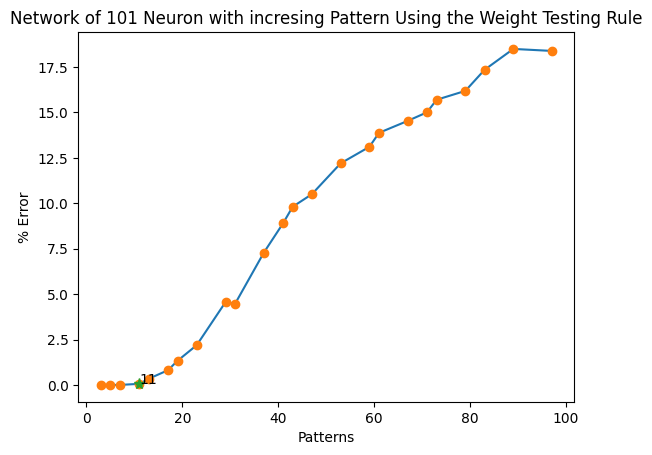

In [16]:

data1 = df1
# data1 = pd.read_csv('data/steady_statez_flip_new_P4_5000_10.csv')
first_error = data1.loc[data1['% Error'] > 0]
first_error.columns = ['Neurons', '% Error', 'patterns', 'iterations']
ndf = first_error.iloc[[0, -1]]
point = ndf.iloc[0]
ndf.reset_index(drop=True, inplace=True)

s = '{}{}{}'.format('Network of ', round(data1.iloc[0]['Neurons']), ' Neuron with incresing Pattern Using the Weight Testing Rule')

plt.plot(data1['number of patterns'],data1['% Error'])
plt.plot(data1['number of patterns'],data1['% Error'],'o')  
plt.plot(point['patterns'],point['% Error'], marker='*', ls='none', ms=8)
plt.annotate(str(round(point['patterns'])), xy=(point['patterns'],point['% Error']))
plt.title(s)
plt.ylabel('% Error')
plt.xlabel('Patterns')

# ax.text(point['number of patterns'],point['% Error'],point['% Error'], size=8)
# plt.show()
plt.savefig("C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/Weight-Based_Simulation_image.png",dpi=1000,
pad_inches = 0,bbox_inches='tight', transparent = False)



del result, df1, data1, error, iterations

In [17]:
# start_time = time.time()
start_times = datetime.now()

for i in b:
    result = []
    for j in tqdm.tqdm(a):
        # neuron = []
        error = []
        iterations = []
        for nn in range(105):
            v = RandomNet(i,j)
            k = np.random.randint(len(v))
            vr = v[k]
            y =  steady_state_flipE(v,vr,2)
            # neuron.append(y[1])
            # print(y[0],y[3],y[5])
            error.append(y[3])
            iterations.append(y[5])
        errors = round(st.mean(error),2)
        iterationss = round(st.mean(iterations),2)
        rr = (y[0],errors,j,iterationss)
        result.append(rr)
        
end_times = datetime.now()
print('\n \n Duration: {}'.format(end_times - start_times))
        
    
df2 = pd.DataFrame(
    result, columns=['Neurons', '% Error', 'number of patterns', 'iterations'], dtype=float)

df2.to_csv("C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/'Energy-Based_E2_Simulation_data_P100.csv",index = False) 



100%|██████████| 24/24 [05:45<00:00, 14.39s/it]


 
 Duration: 0:05:45.336992


In [18]:
pd.concat([df2.head(5), df2.tail(2)])

,Neurons,% Error,number of patterns,iterations
0,101.0,0.00,3.0,1.00
1,101.0,0.00,5.0,1.00
2,101.0,0.00,7.0,1.00
3,101.0,0.04,11.0,1.00
4,101.0,0.26,13.0,1.17
22,101.0,18.44,89.0,99.00
23,101.0,18.96,97.0,98.71


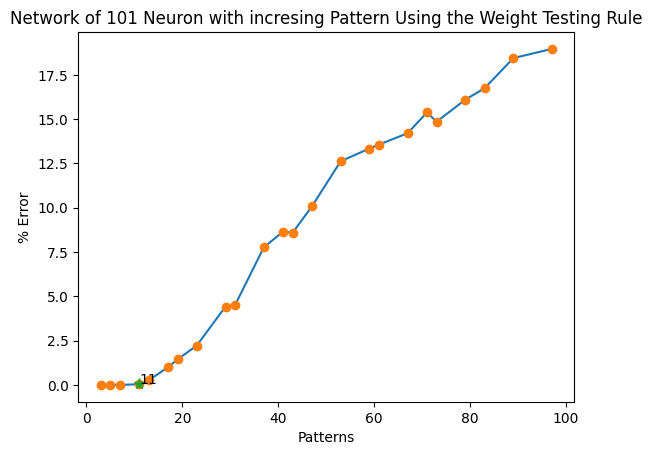

In [19]:

data2 = df2
# data1 = pd.read_csv('data/steady_statez_flip_new_P4_5000_10.csv')
first_error = data2.loc[data2['% Error'] > 0]
first_error.columns = ['Neurons', '% Error', 'patterns', 'iterations']
ndf = first_error.iloc[[0, -1]]
point = ndf.iloc[0]
ndf.reset_index(drop=True, inplace=True)

s = '{}{}{}'.format('Network of ', round(data2.iloc[0]['Neurons']), ' Neuron with incresing Pattern Using the Weight Testing Rule')

plt.plot(data2['number of patterns'],data2['% Error'])
plt.plot(data2['number of patterns'],data2['% Error'],'o')  
plt.plot(point['patterns'],point['% Error'], marker='*', ls='none', ms=8)
plt.annotate(str(round(point['patterns'])), xy=(point['patterns'],point['% Error']))
plt.title(s)
plt.ylabel('% Error')
plt.xlabel('Patterns')

# ax.text(point['number of patterns'],point['% Error'],point['% Error'], size=8)
# plt.show()
plt.savefig("C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/Energy-Based_E2_Simulation_image_P100.png",dpi=1000,
pad_inches = 0,bbox_inches='tight', transparent = False)


del result, df2, data2, error, iterations, first_error, ndf, point

In [20]:
# start_time = time.time()
start_times = datetime.now()

for i in b:
    result = []
    for j in tqdm.tqdm(a):
        # neuron = []
        error = []
        iterations = []
        for nn in range(105):
            v = RandomNet(i,j)
            k = np.random.randint(len(v))
            vr = v[k]
            y =  steady_state_flipE(v,vr,4)
            # neuron.append(y[1])
            # print(y[0],y[3],y[5])
            error.append(y[3])
            iterations.append(y[5])
        errors = round(st.mean(error),2)
        iterationss = round(st.mean(iterations),2)
        rr = (y[0],errors,j,iterationss)
        result.append(rr)

end_times = datetime.now()
print('\n \n Duration: {}'.format(end_times - start_times))
        
    
df3 = pd.DataFrame(
    result, columns=['Neurons', '% Error', 'number of patterns', 'iterations'], dtype=float)

df3.to_csv("C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/'Energy-Based_E4_Simulation_data_P100.csv",index = False) 



100%|██████████| 24/24 [00:10<00:00,  2.31it/s]


 
 Duration: 0:00:10.406794


In [21]:
pd.concat([df3.head(5), df3.tail(2)])

,Neurons,% Error,number of patterns,iterations
0,101.0,0.0,3.0,1.0
1,101.0,0.0,5.0,1.0
2,101.0,0.0,7.0,1.0
3,101.0,0.0,11.0,1.0
4,101.0,0.0,13.0,1.0
22,101.0,0.0,89.0,1.0
23,101.0,0.0,97.0,1.0


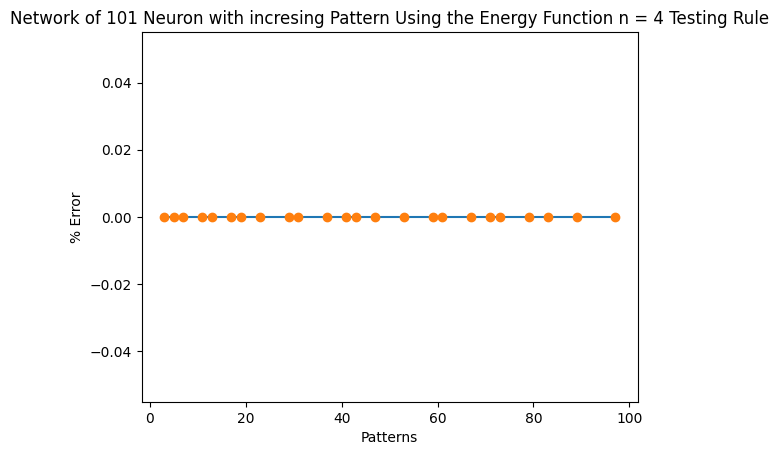

In [22]:

data3 = df3
# data1 = pd.read_csv('data/steady_statez_flip_new_P4_5000_10.csv')
first_error = data3.loc[data3['% Error'] > 0]
first_error.columns = ['Neurons', '% Error', 'patterns', 'iterations']
# ndf = first_error.iloc[[0, -1]]
# point = ndf.iloc[0]
# ndf.reset_index(drop=True, inplace=True)

s = '{}{}{}'.format('Network of ', round(data3.iloc[0]['Neurons']), ' Neuron with incresing Pattern Using the Energy Function n = 4 Testing Rule')

plt.plot(data3['number of patterns'],data3['% Error'])
plt.plot(data3['number of patterns'],data3['% Error'],'o')  
# plt.plot(data3['patterns'],point['% Error'], marker='*', ls='none', ms=8)
# plt.annotate(str(round(point['patterns'])), xy=(point['patterns'],point['% Error']))
plt.title(s)
plt.ylabel('% Error')
plt.xlabel('Patterns')

# ax.text(point['number of patterns'],point['% Error'],point['% Error'], size=8)
# plt.show()
plt.savefig("C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/Energy-Based_E4_Simulation_image_P100.png",dpi=1000,
pad_inches = 0,bbox_inches='tight', transparent = False)



del result, df3, data3, error, iterations, first_error

In [24]:

g = prime_generator(4000)     # give firt 1000 prime numbers
a = list(g)
q = Prime_range(100,102)
b = list(q)

In [25]:
# start_time = time.time()
start_times = datetime.now()

for i in b:
    result = []
    for j in tqdm.tqdm(a):
        # neuron = []
        error = []
        iterations = []
        for nn in range(10):
            v = RandomNet(i,j)
            k = np.random.randint(len(v))
            vr = v[k]
            y =  steady_state_flipE(v,vr,4)
            # neuron.append(y[1])
            # print(y[0],y[3],y[5])
            error.append(y[3])
            iterations.append(y[5])
        errors = round(st.mean(error),2)
        iterationss = round(st.mean(iterations),2)
        rr = (y[0],errors,j,iterationss)
        result.append(rr)
        

end_times = datetime.now()
print('\n \n Duration: {}'.format(end_times - start_times))
        
    
df4 = pd.DataFrame(
    result, columns=['Neurons', '% Error', 'number of patterns', 'iterations'], dtype=float)

df4.to_csv("C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/'Energy-Based_E4_Simulation_data_P4000.csv",index = False) 



100%|██████████| 549/549 [05:50<00:00,  1.56it/s]


 
 Duration: 0:05:50.912224


In [26]:
pd.concat([df4.head(5), df4.tail(2)])

,Neurons,% Error,number of patterns,iterations
0,101.0,0.0,3.0,1.0
1,101.0,0.0,5.0,1.0
2,101.0,0.0,7.0,1.0
3,101.0,0.0,11.0,1.0
4,101.0,0.0,13.0,1.0
547,101.0,0.0,3967.0,1.0
548,101.0,0.0,3989.0,1.0


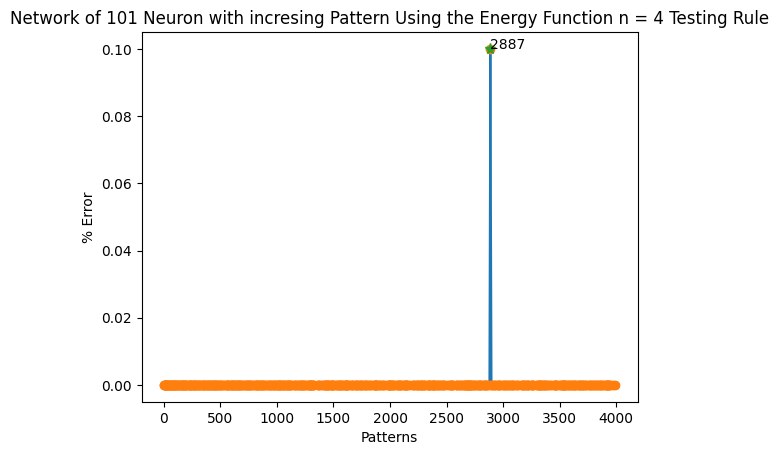

In [29]:

data4 = df4
# data1 = pd.read_csv('data/steady_statez_flip_new_P4_5000_10.csv')
first_error = data4.loc[data4['% Error'] > 0]
first_error.columns = ['Neurons', '% Error', 'patterns', 'iterations']
ndf = first_error.iloc[[0, -1]]
point = ndf.iloc[0]
ndf.reset_index(drop=True, inplace=True)

s = '{}{}{}'.format('Network of ', round(data4.iloc[0]['Neurons']), ' Neuron with incresing Pattern Using the Energy Function n = 4 Testing Rule')

plt.plot(data4['number of patterns'],data4['% Error'])
plt.plot(data4['number of patterns'],data4['% Error'],'o')  
plt.plot(point['patterns'],point['% Error'], marker='*', ls='none', ms=8)
plt.annotate(str(round(point['patterns'])), xy=(point['patterns'],point['% Error']))
plt.title(s)
plt.ylabel('% Error')
plt.xlabel('Patterns')

# ax.text(point['number of patterns'],point['% Error'],point['% Error'], size=8)
# plt.show()
plt.savefig("C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/Energy-Based_E4_Simulation_image_P4000.png",dpi=1000,
pad_inches = 0,bbox_inches='tight', transparent = False)



del result, df4, data4, error, iterations, first_error, ndf, point



In [30]:

g = prime_generator(6000)     # give firt 1000 prime numbers
a = list(g)
q = Prime_range(100,102)
b = list(q)

In [31]:
# start_time = time.time()
start_times = datetime.now()

for i in b:
    result = []
    for j in tqdm.tqdm(a):
        # neuron = []
        error = []
        iterations = []
        for nn in range(10):
            v = RandomNet(i,j)
            k = np.random.randint(len(v))
            vr = v[k]
            y =  steady_state_flipE(v,vr,4)
            # neuron.append(y[1])
            # print(y[0],y[3],y[5])
            error.append(y[3])
            iterations.append(y[5])
        errors = round(st.mean(error),2)
        iterationss = round(st.mean(iterations),2)
        rr = (y[0],errors,j,iterationss)
        result.append(rr)
        
end_times = datetime.now()
print('\n \n Duration: {}'.format(end_times - start_times))
        
    
df5 = pd.DataFrame(
    result, columns=['Neurons', '% Error', 'number of patterns', 'iterations'], dtype=float)

df5.to_csv("C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/'Energy-Based_E4_Simulation_data_P6000.csv",index = False) 



100%|██████████| 782/782 [10:06<00:00,  1.29it/s]


 
 Duration: 0:10:06.962618


In [32]:
pd.concat([df5.head(5), df5.tail(2)])

,Neurons,% Error,number of patterns,iterations
0,101.0,0.0,3.0,1.0
1,101.0,0.0,5.0,1.0
2,101.0,0.0,7.0,1.0
3,101.0,0.0,11.0,1.0
4,101.0,0.0,13.0,1.0
780,101.0,0.0,5981.0,1.0
781,101.0,0.0,5987.0,1.0


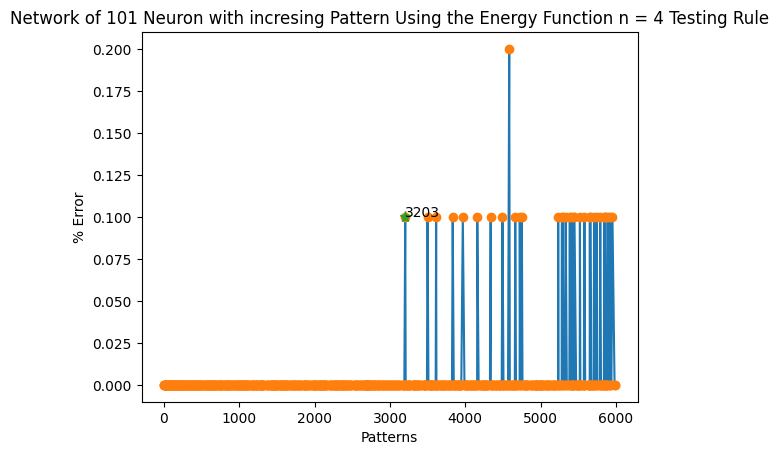

In [33]:

data5 = df5
# data1 = pd.read_csv('data/steady_statez_flip_new_P4_5000_10.csv')
first_error = data5.loc[data5['% Error'] > 0]
first_error.columns = ['Neurons', '% Error', 'patterns', 'iterations']
ndf = first_error.iloc[[0, -1]]
point = ndf.iloc[0]
ndf.reset_index(drop=True, inplace=True)

s = '{}{}{}'.format('Network of ', round(data5.iloc[0]['Neurons']), ' Neuron with incresing Pattern Using the Energy Function n = 4 Testing Rule')

plt.plot(data5['number of patterns'],data5['% Error'])
plt.plot(data5['number of patterns'],data5['% Error'],'o')  
plt.plot(point['patterns'],point['% Error'], marker='*', ls='none', ms=8)
plt.annotate(str(round(point['patterns'])), xy=(point['patterns'],point['% Error']))
plt.title(s)
plt.ylabel('% Error')
plt.xlabel('Patterns')

# ax.text(point['number of patterns'],point['% Error'],point['% Error'], size=8)
# plt.show()
plt.savefig("C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/Energy-Based_E4_Simulation_image_P6000.png",dpi=1000,
pad_inches = 0,bbox_inches='tight', transparent = False)



del result, df5, data5, error, iterations, first_error, ndf, point

In [34]:

g = prime_generator(10000)     # give firt 1000 prime numbers
a = list(g)
q = Prime_range(100,102)
b = list(q)

In [35]:
# start_time = time.time()
start_times = datetime.now()

for i in b:
    result = []
    for j in tqdm.tqdm(a):
        # neuron = []
        error = []
        iterations = []
        for nn in range(5):
            v = RandomNet(i,j)
            k = np.random.randint(len(v))
            vr = v[k]
            y =  steady_state_flipE(v,vr,4)
            # neuron.append(y[1])
            # print(y[0],y[3],y[5])
            error.append(y[3])
            iterations.append(y[5])
        errors = round(st.mean(error),2)
        iterationss = round(st.mean(iterations),2)
        rr = (y[0],errors,j,iterationss)
        result.append(rr)
        
end_times = datetime.now()
print('\n \n Duration: {}'.format(end_times - start_times))
        
    
df6 = pd.DataFrame(
    result, columns=['Neurons', '% Error', 'number of patterns', 'iterations'], dtype=float)

df6.to_csv("C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/'Energy-Based_E4_Simulation_data_P10000.csv",index = False) 



100%|██████████| 1228/1228 [10:41<00:00,  1.91it/s]


 
 Duration: 0:10:41.669696


In [36]:
pd.concat([df6.head(5), df6.tail(2)])

,Neurons,% Error,number of patterns,iterations
0,101.0,0.0,3.0,1.0
1,101.0,0.0,5.0,1.0
2,101.0,0.0,7.0,1.0
3,101.0,0.0,11.0,1.0
4,101.0,0.0,13.0,1.0
1226,101.0,0.0,9967.0,1.0
1227,101.0,0.6,9973.0,1.0


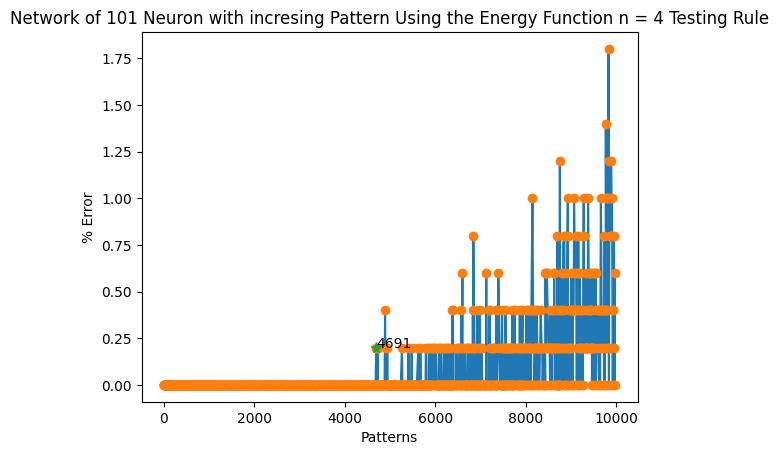

In [37]:

data6 = df6
# data1 = pd.read_csv('data/steady_statez_flip_new_P4_5000_10.csv')
first_error = data6.loc[data6['% Error'] > 0]
first_error.columns = ['Neurons', '% Error', 'patterns', 'iterations']
ndf = first_error.iloc[[0, -1]]
point = ndf.iloc[0]
ndf.reset_index(drop=True, inplace=True)

s = '{}{}{}'.format('Network of ', round(data6.iloc[0]['Neurons']), ' Neuron with incresing Pattern Using the Energy Function n = 4 Testing Rule')

plt.plot(data6['number of patterns'],data6['% Error'])
plt.plot(data6['number of patterns'],data6['% Error'],'o')  
plt.plot(point['patterns'],point['% Error'], marker='*', ls='none', ms=8)
plt.annotate(str(round(point['patterns'])), xy=(point['patterns'],point['% Error']))
plt.title(s)
plt.ylabel('% Error')
plt.xlabel('Patterns')

# ax.text(point['number of patterns'],point['% Error'],point['% Error'], size=8)
# plt.show()
plt.savefig("C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/Energy-Based_E4_Simulation_image_P10000.png",dpi=1000,
pad_inches = 0,bbox_inches='tight', transparent = False)



del result, df6, data6, error, iterations, first_error, ndf, point

# Read in the data

In [ ]:
df1 = pd.read_csv(r'C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/steady_statez_flip_new_P2.csv')
df2 = pd.read_csv(r'C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/steady_statez_flip_new_P4_100.csv')
df3 = pd.read_csv(r'C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/steady_statez_flip_new_P4_5000_10.csv')
df4 = pd.read_csv(r'C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/steady_statez_flip_new_P4_6000_10.csv')
df5 = pd.read_csv(r'C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/steady_statez_flip_new_P2_10000_2.csv')
# df6 = pd.read_csv(r'C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/steady_statez_flip_new_P2.csv')
# df7 = pd.read_csv(r'C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/steady_statez_flip_new_P2.csv')
# df8 = pd.read_csv(r'C:/Users/scrwh/Documents/rmarkdown/hopfield_Network/data/steady_statez_flip_new_P2.csv')